In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from pylab import *

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # ignoring future warning 
warnings.filterwarnings("ignore", category=DeprecationWarning)  # ignoring deprecation warning 
warnings.filterwarnings("ignore", category=UserWarning)  # ignoring user warning 

In [3]:
df= pd.read_csv('LoansGoodBad.csv')
df.head()

,RowID,Loan_Amount,Term,Interest_Rate,Employment_Years,Home_Ownership,Annual_Income,Verification_Status,Loan_Purpose,State,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length
0,1,5000.0,36 months,10.65,10.0,RENT,24000.0,VERIFIED - income,credit_card,AZ,27.65,0.0,83.7,9.0,GOOD,26.0
1,2,2500.0,60 months,15.27,0.5,RENT,30000.0,VERIFIED - income source,car,GA,1.00,0.0,9.4,4.0,BAD,12.0
2,3,2400.0,36 months,15.96,10.0,RENT,12252.0,not verified,small_business,IL,8.72,0.0,98.5,10.0,GOOD,10.0
3,4,10000.0,36 months,13.49,10.0,RENT,49200.0,VERIFIED - income source,other,CA,20.00,0.0,21.0,37.0,GOOD,15.0
4,5,5000.0,36 months,7.90,3.0,RENT,36000.0,VERIFIED - income source,wedding,AZ,11.20,0.0,28.3,12.0,GOOD,7.0


In [4]:
df=df.iloc[:,1:]
df.head()

,Loan_Amount,Term,Interest_Rate,Employment_Years,Home_Ownership,Annual_Income,Verification_Status,Loan_Purpose,State,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length
0,5000.0,36 months,10.65,10.0,RENT,24000.0,VERIFIED - income,credit_card,AZ,27.65,0.0,83.7,9.0,GOOD,26.0
1,2500.0,60 months,15.27,0.5,RENT,30000.0,VERIFIED - income source,car,GA,1.00,0.0,9.4,4.0,BAD,12.0
2,2400.0,36 months,15.96,10.0,RENT,12252.0,not verified,small_business,IL,8.72,0.0,98.5,10.0,GOOD,10.0
3,10000.0,36 months,13.49,10.0,RENT,49200.0,VERIFIED - income source,other,CA,20.00,0.0,21.0,37.0,GOOD,15.0
4,5000.0,36 months,7.90,3.0,RENT,36000.0,VERIFIED - income source,wedding,AZ,11.20,0.0,28.3,12.0,GOOD,7.0


In [5]:
df.shape

(163994, 15)

In [6]:
#Missing Values
pd.DataFrame(pd.concat([df.isnull().sum(),df.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
Employment_Years,5811,3.543422
Revolving_Cr_Util,200,0.121956
Delinquent_2yr,36,0.021952
Total_Accounts,36,0.021952
Longest_Credit_Length,36,0.021952
Annual_Income,11,0.006708
Loan_Amount,7,0.004268
Term,7,0.004268
Interest_Rate,7,0.004268
Home_Ownership,7,0.004268


In [7]:
df.dtypes

Loan_Amount              float64
Term                      object
Interest_Rate            float64
Employment_Years         float64
Home_Ownership            object
Annual_Income            float64
Verification_Status       object
Loan_Purpose              object
State                     object
Debt_to_Income           float64
Delinquent_2yr           float64
Revolving_Cr_Util        float64
Total_Accounts           float64
Bad_Loan                  object
Longest_Credit_Length    float64
dtype: object

# Data Cleaning

In [8]:
# Removing duplicate values
df = df.drop_duplicates().reset_index(drop = True)
df.shape

(163988, 15)

In [9]:
# Loan_Amount, Interest_Rate, Employment_Years, Annual_Income, Debt_to_Income, Delinquent_2yr, Revolving_Cr_Util, Total_Accounts, Longest_Credit_Length
df.describe()

,Loan_Amount,Interest_Rate,Employment_Years,Annual_Income,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Longest_Credit_Length
count,163987.000000,163987.000000,158183.000000,1.639830e+05,163987.000000,163958.000000,163794.000000,163958.000000,163958.000000
mean,13074.169141,13.715904,5.729389,7.191567e+04,15.881530,0.227357,54.079173,24.579734,14.854274
std,7993.556189,4.391940,3.541945,5.907092e+04,7.587668,0.694168,25.285367,11.685190,6.947733
min,500.000000,5.420000,0.500000,1.896000e+03,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7000.000000,10.650000,2.000000,4.500000e+04,10.230000,0.000000,35.600000,16.000000,10.000000
50%,11325.000000,13.490000,6.000000,6.100000e+04,15.620000,0.000000,55.800000,23.000000,14.000000
75%,18000.000000,16.320000,10.000000,8.500000e+04,21.260000,0.000000,74.200000,31.000000,18.000000
max,35000.000000,26.060000,10.000000,7.141778e+06,39.990000,29.000000,150.700000,118.000000,65.000000


In [10]:
# Term
df['Term'].value_counts()

36 months    129950
60 months     34037
Name: Term, dtype: int64

In [11]:
# Home_Ownership
df['Home_Ownership'].value_counts()

MORTGAGE    79714
RENT        70526
OWN         13560
OTHER         156
NONE           30
ANY             1
Name: Home_Ownership, dtype: int64

In [12]:
#df['Home_Ownership'] = df['Home_Ownership'].replace('OTHER',np.nan).replace('ANY',np.nan)
#df['Home_Ownership'].value_counts()

In [13]:
# Verification_Status
df['Verification_Status'].value_counts()

VERIFIED - income           60875
not verified                59155
VERIFIED - income source    43957
Name: Verification_Status, dtype: int64

In [14]:
df['Verification_Status'] = df['Verification_Status'].replace('VERIFIED - income source','verified - income source').replace('VERIFIED - income','verified - income')
df['Verification_Status'].value_counts()

verified - income           60875
not verified                59155
verified - income source    43957
Name: Verification_Status, dtype: int64

In [15]:
#df['Verification_Status'] = df['Verification_Status'].replace('VERIFIED - income source','verified - income').replace('VERIFIED - income','verified - income')
#df['Verification_Status'].value_counts()

In [16]:
# Loan_Purpose
df['Loan_Purpose'].value_counts()

debt_consolidation    93261
credit_card           30792
other                 10492
home_improvement       9872
major_purchase         4686
small_business         3841
car                    2842
medical                2029
wedding                1751
moving                 1464
house                  1245
vacation               1096
educational             418
renewable_energy        198
Name: Loan_Purpose, dtype: int64

In [17]:
# State
df['State'].value_counts()

CA    28702
NY    14285
TX    12128
FL    11396
NJ     6457
IL     6099
PA     5427
VA     5282
GA     5189
OH     4896
NC     4393
MA     4164
AZ     3941
MD     3890
WA     3823
MI     3762
CO     3531
MN     2771
MO     2627
CT     2563
NV     2387
OR     2149
WI     1980
AL     1965
LA     1885
SC     1826
KY     1477
IN     1463
UT     1389
KS     1335
OK     1331
TN     1327
AR     1104
HI      955
NM      839
NH      752
WV      714
RI      695
DC      584
MT      483
DE      445
AK      413
WY      376
SD      317
VT      270
MS      163
NE       13
IA       12
ID        9
ME        3
Name: State, dtype: int64

In [18]:
# Bad_Loan
df['Bad_Loan'].value_counts()

GOOD    133972
BAD      30016
Name: Bad_Loan, dtype: int64

# EDA

In [19]:
df_eda = df.copy()

In [20]:
df_eda['Bad_Loan'].value_counts()/len(df_eda)

GOOD    0.816962
BAD     0.183038
Name: Bad_Loan, dtype: float64

Text(0.5, 1.0, '% Good/Bad Loans')

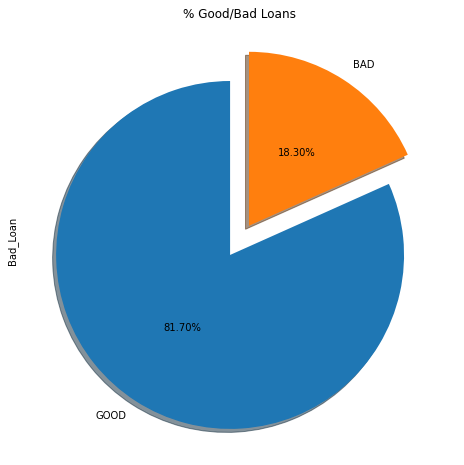

In [21]:
# Pie chart
plt.rcParams['figure.figsize'] = (15, 8)
index=df_eda['Bad_Loan'].value_counts().index
df_eda['Bad_Loan'].value_counts().plot(kind = 'pie', explode = [0.1, 0.1], autopct = '%.2f%%', startangle = 90,labels = index, shadow = True, pctdistance = 0.5)
plt.title("% Good/Bad Loans")

#### This is clearly an imbalanced dataset.

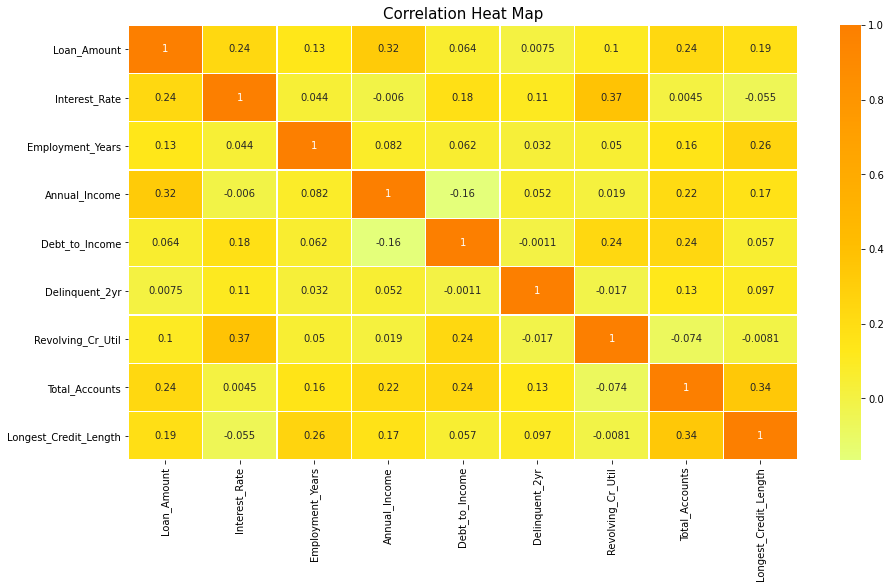

In [22]:
# heatmap using correlation matrix
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_eda.corr(), annot = True, linewidth = 0.5, cmap = 'Wistia')
plt.title('Correlation Heat Map', fontsize = 15)
plt.show()

In [23]:
df.dtypes

Loan_Amount              float64
Term                      object
Interest_Rate            float64
Employment_Years         float64
Home_Ownership            object
Annual_Income            float64
Verification_Status       object
Loan_Purpose              object
State                     object
Debt_to_Income           float64
Delinquent_2yr           float64
Revolving_Cr_Util        float64
Total_Accounts           float64
Bad_Loan                  object
Longest_Credit_Length    float64
dtype: object

In [24]:
num_var = [i for i in df.columns if df[i].dtype!='O']

In [25]:
scaler =StandardScaler()
df_eda_scaled = pd.DataFrame(scaler.fit_transform(df_eda[num_var]),columns = df_eda[num_var].columns)
df_eda_scaled.head()

,Loan_Amount,Interest_Rate,Employment_Years,Annual_Income,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Longest_Credit_Length
0,-1.010088,-0.698077,1.205729,-0.811158,1.551004,-0.327526,1.171465,-1.333293,1.604230
1,-1.322841,0.353853,-1.476422,-0.709584,-1.961284,-0.327526,-1.767003,-1.761186,-0.410822
2,-1.335351,0.510959,1.205729,-1.010038,-0.943841,-0.327526,1.756785,-1.247714,-0.698687
3,-0.384582,-0.051436,1.205729,-0.384550,0.542786,-0.327526,-1.308238,1.062910,0.020975
4,-1.010088,-1.324226,-0.770593,-0.608011,-0.616994,-0.327526,-1.019532,-1.076557,-1.130484


In [26]:
variables = df_eda_scaled.dropna().copy()
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = df_eda_scaled.columns
vif

,VIF,Features
0,1.261549,Loan_Amount
1,1.277401,Interest_Rate
2,1.088632,Employment_Years
3,1.226520,Annual_Income
4,1.232278,Debt_to_Income
5,1.043889,Delinquent_2yr
6,1.244353,Revolving_Cr_Util
7,1.341798,Total_Accounts
8,1.241127,Longest_Credit_Length


In [27]:
del df_eda_scaled

#### There is no multi-collinearity

Text(0.5, 1.0, 'Loan_Amount w.r.t Bad_Loan')

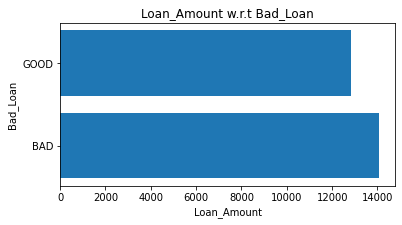

In [28]:
#  Loan_Amount w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Loan_Amount']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Loan_Amount')
plt.ylabel('Bad_Loan')
plt.title('Loan_Amount w.r.t Bad_Loan')

Text(0.5, 1.0, 'Interest_Rate w.r.t Bad_Loan')

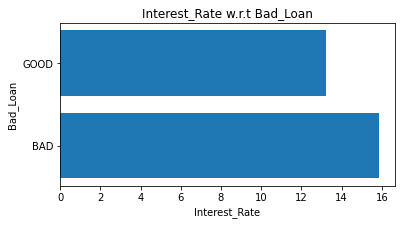

In [29]:
#  Interest_Rate w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Interest_Rate']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Interest_Rate')
plt.ylabel('Bad_Loan')
plt.title('Interest_Rate w.r.t Bad_Loan')

Text(0.5, 1.0, 'Employment_Years w.r.t Bad_Loan')

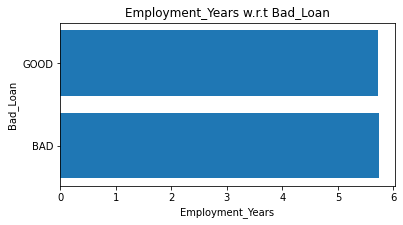

In [30]:
#  Employment_Years w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Employment_Years']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Employment_Years')
plt.ylabel('Bad_Loan')
plt.title('Employment_Years w.r.t Bad_Loan')

Text(0.5, 1.0, 'Annual_Income w.r.t Bad_Loan')

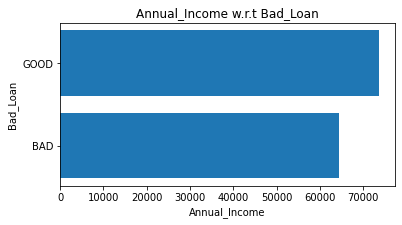

In [31]:
#  Annual_Income w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Annual_Income']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Annual_Income')
plt.ylabel('Bad_Loan')
plt.title('Annual_Income w.r.t Bad_Loan')

Text(0.5, 1.0, 'Debt_to_Income w.r.t Bad_Loan')

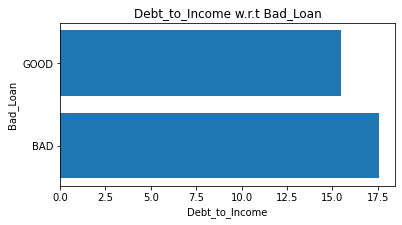

In [32]:
#  Debt_to_Income w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Debt_to_Income']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Debt_to_Income')
plt.ylabel('Bad_Loan')
plt.title('Debt_to_Income w.r.t Bad_Loan')

Text(0.5, 1.0, 'Delinquent_2yr w.r.t Bad_Loan')

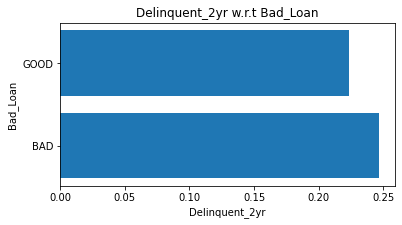

In [33]:
#  Delinquent_2yr w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Delinquent_2yr']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Delinquent_2yr')
plt.ylabel('Bad_Loan')
plt.title('Delinquent_2yr w.r.t Bad_Loan')

Text(0.5, 1.0, 'Revolving_Cr_Util w.r.t Bad_Loan')

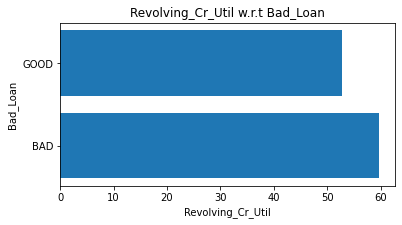

In [34]:
#  Revolving_Cr_Util w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Revolving_Cr_Util']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Revolving_Cr_Util')
plt.ylabel('Bad_Loan')
plt.title('Revolving_Cr_Util w.r.t Bad_Loan')

Text(0.5, 1.0, 'Total_Accounts w.r.t Bad_Loan')

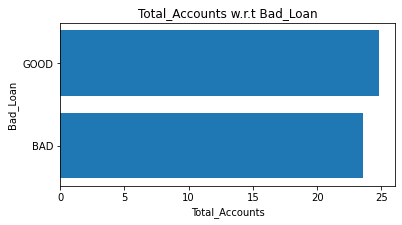

In [35]:
#  Total_Accounts w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Total_Accounts']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Total_Accounts')
plt.ylabel('Bad_Loan')
plt.title('Total_Accounts w.r.t Bad_Loan')

Text(0.5, 1.0, 'Longest_Credit_Length w.r.t Bad_Loan')

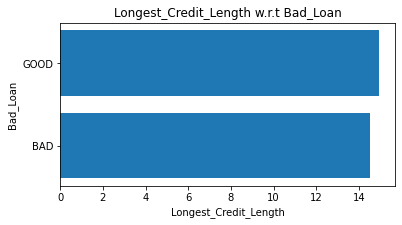

In [36]:
#  Longest_Credit_Length w.r.t Bad_Loan
x=df_eda.groupby('Bad_Loan').apply(lambda x: np.mean(x['Longest_Credit_Length']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('Longest_Credit_Length')
plt.ylabel('Bad_Loan')
plt.title('Longest_Credit_Length w.r.t Bad_Loan')

In [37]:
df_eda['Bad_Loan'] = df_eda['Bad_Loan'].map({'BAD':1,'GOOD':0})

Text(0.5, 1.0, 'Term w.r.t Bad_Loan')

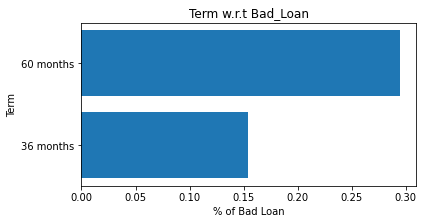

In [38]:
#  Term w.r.t Bad_Loan
x=df_eda.groupby('Term').apply(lambda x: np.mean(x['Bad_Loan']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('% of Bad Loan')
plt.ylabel('Term')
plt.title('Term w.r.t Bad_Loan')

Text(0.5, 1.0, 'Home_Ownership w.r.t Bad_Loan')

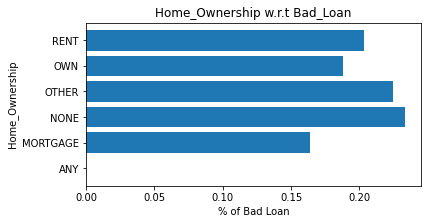

In [39]:
#  Home_Ownership w.r.t Bad_Loan
x=df_eda.groupby('Home_Ownership').apply(lambda x: np.mean(x['Bad_Loan']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('% of Bad Loan')
plt.ylabel('Home_Ownership')
plt.title('Home_Ownership w.r.t Bad_Loan')

Text(0.5, 1.0, 'Verification_Status w.r.t Bad_Loan')

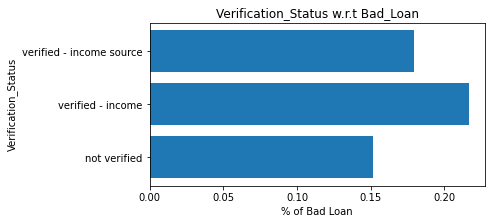

In [40]:
#  Verification_Status w.r.t Bad_Loan
x=df_eda.groupby('Verification_Status').apply(lambda x: np.mean(x['Bad_Loan']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('% of Bad Loan')
plt.ylabel('Verification_Status')
plt.title('Verification_Status w.r.t Bad_Loan')

Text(0.5, 1.0, 'Loan_Purpose w.r.t Bad_Loan')

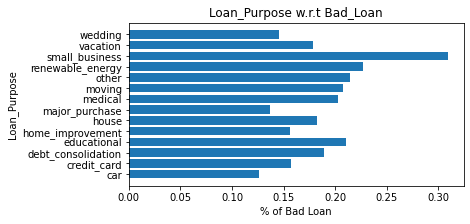

In [41]:
#  Loan_Purpose w.r.t Bad_Loan
x=df_eda.groupby('Loan_Purpose').apply(lambda x: np.mean(x['Bad_Loan']))
fig,ax=plt.subplots(figsize=(6,3))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('% of Bad Loan')
plt.ylabel('Loan_Purpose')
plt.title('Loan_Purpose w.r.t Bad_Loan')

Text(0.5, 1.0, 'State w.r.t Bad_Loan')

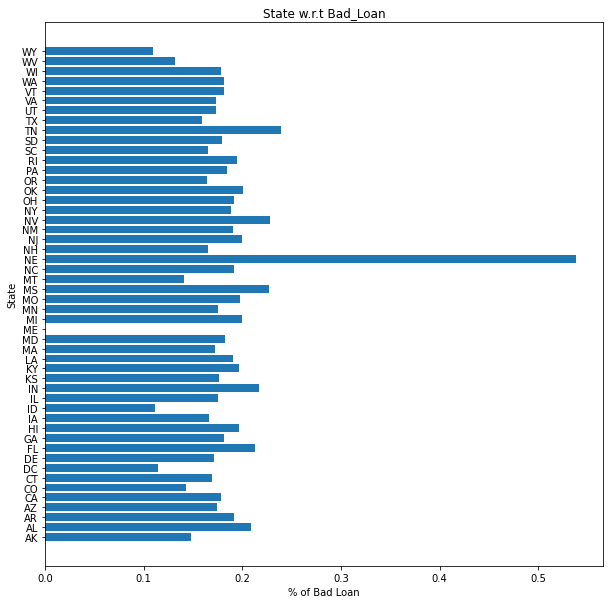

In [42]:
#  State w.r.t Bad_Loan
x=df_eda.groupby('State').apply(lambda x: np.mean(x['Bad_Loan']))
fig,ax=plt.subplots(figsize=(10,10))
ax.barh(y=range(len(x)), width=x.values,align='center')
ax.set(yticks= np.arange(len(x)),yticklabels = x.index)
plt.xlabel('% of Bad Loan')
plt.ylabel('State')
plt.title('State w.r.t Bad_Loan')

In [43]:
del df_eda

# Statistical Analysis

In [44]:
df_test = df.dropna().reset_index(drop=True).copy()

In [45]:
target_Bad = df_test[df_test['Bad_Loan']=='BAD']
target_Good = df_test[df_test['Bad_Loan']=='GOOD']
print(target_Bad.shape[0],target_Good.shape[0])

28451 129545


Text(0, 0.5, 'Loan_Amount')

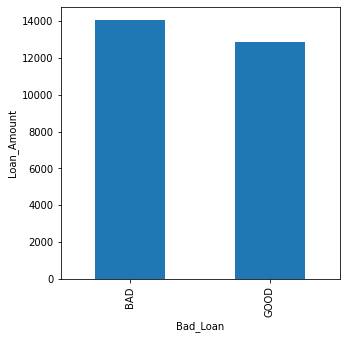

In [46]:
#  Loan_Amount w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Loan_Amount'].plot.bar()
plt.ylabel("Loan_Amount")

In [47]:
ztest ,pval = stests.ztest(x1=target_Bad['Loan_Amount'], x2=target_Good['Loan_Amount'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

4.937132363551648e-140
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Loan_Amount

Text(0, 0.5, 'Interest_Rate')

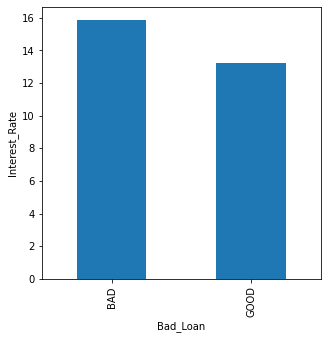

In [48]:
#  Interest_Rate w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Interest_Rate'].plot.bar()
plt.ylabel("Interest_Rate")

In [49]:
ztest ,pval = stests.ztest(x1=target_Bad['Interest_Rate'], x2=target_Good['Interest_Rate'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

0.0
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Interest_Rate

Text(0, 0.5, 'Employment_Years')

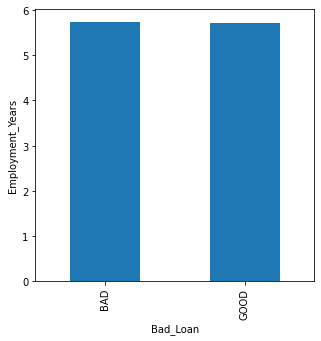

In [50]:
#  Employment_Years w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Employment_Years'].plot.bar()
plt.ylabel("Employment_Years")

In [51]:
ztest ,pval = stests.ztest(x1=target_Bad['Employment_Years'], x2=target_Good['Employment_Years'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

0.591759624882989
Failed to reject null hypothesis


#### According to z test, Bad_Loan is independent upon Employment_Years

In [52]:
df = df.drop(columns = 'Employment_Years')
df.head()

,Loan_Amount,Term,Interest_Rate,Home_Ownership,Annual_Income,Verification_Status,Loan_Purpose,State,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length
0,5000.0,36 months,10.65,RENT,24000.0,verified - income,credit_card,AZ,27.65,0.0,83.7,9.0,GOOD,26.0
1,2500.0,60 months,15.27,RENT,30000.0,verified - income source,car,GA,1.00,0.0,9.4,4.0,BAD,12.0
2,2400.0,36 months,15.96,RENT,12252.0,not verified,small_business,IL,8.72,0.0,98.5,10.0,GOOD,10.0
3,10000.0,36 months,13.49,RENT,49200.0,verified - income source,other,CA,20.00,0.0,21.0,37.0,GOOD,15.0
4,5000.0,36 months,7.90,RENT,36000.0,verified - income source,wedding,AZ,11.20,0.0,28.3,12.0,GOOD,7.0


Text(0, 0.5, 'Annual_Income')

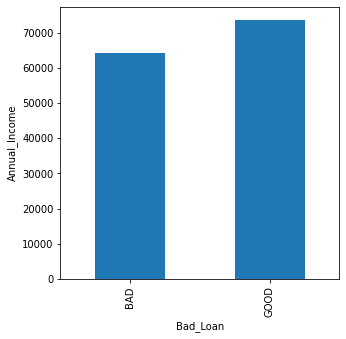

In [53]:
#  Annual_Income w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Annual_Income'].plot.bar()
plt.ylabel("Annual_Income")

In [54]:
ztest ,pval = stests.ztest(x1=target_Bad['Annual_Income'], x2=target_Good['Annual_Income'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

1.3382016761783533e-117
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Annual_Income

Text(0, 0.5, 'Debt_to_Income')

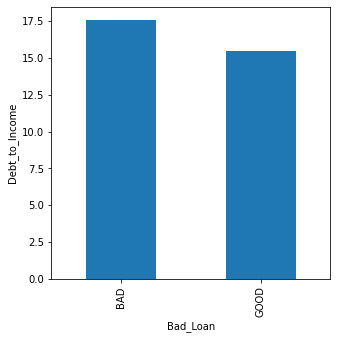

In [55]:
#  Debt_to_Income w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Debt_to_Income'].plot.bar()
plt.ylabel("Debt_to_Income")

In [56]:
ztest ,pval = stests.ztest(x1=target_Bad['Debt_to_Income'], x2=target_Good['Debt_to_Income'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

0.0
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Debt_to_Income

Text(0, 0.5, 'Delinquent_2yr')

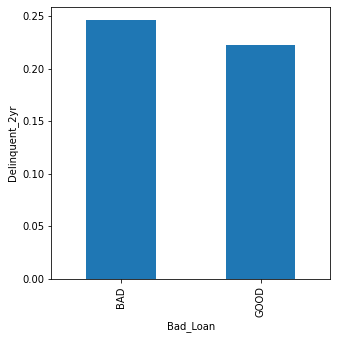

In [57]:
#  Delinquent_2yr w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Delinquent_2yr'].plot.bar()
plt.ylabel("Delinquent_2yr")

In [58]:
ztest ,pval = stests.ztest(x1=target_Bad['Delinquent_2yr'], x2=target_Good['Delinquent_2yr'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

3.941800908659392e-07
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Delinquent_2yr

Text(0, 0.5, 'Revolving_Cr_Util')

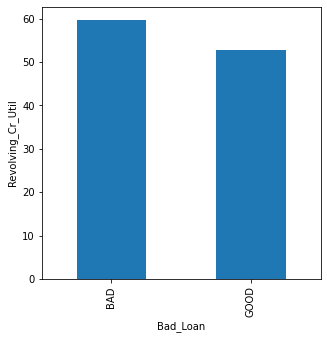

In [59]:
#  Revolving_Cr_Util w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Revolving_Cr_Util'].plot.bar()
plt.ylabel("Revolving_Cr_Util")

In [60]:
ztest ,pval = stests.ztest(x1=target_Bad['Revolving_Cr_Util'], x2=target_Good['Revolving_Cr_Util'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

0.0
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Revolving_Cr_Util

Text(0, 0.5, 'Total_Accounts')

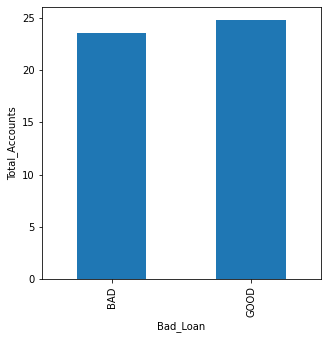

In [61]:
#  Total_Accounts w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Total_Accounts'].plot.bar()
plt.ylabel("Total_Accounts")

In [62]:
ztest ,pval = stests.ztest(x1=target_Bad['Total_Accounts'], x2=target_Good['Total_Accounts'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

2.3665048139894374e-54
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Total_Accounts

Text(0, 0.5, 'Longest_Credit_Length')

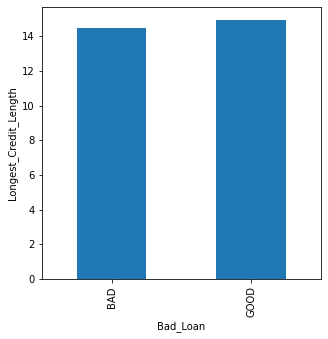

In [63]:
#  Longest_Credit_Length w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df.groupby('Bad_Loan').mean()['Longest_Credit_Length'].plot.bar()
plt.ylabel("Longest_Credit_Length")

In [64]:
ztest ,pval = stests.ztest(x1=target_Bad['Longest_Credit_Length'], x2=target_Good['Longest_Credit_Length'], value=0,alternative='two-sided')
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

5.6555516880292425e-30
Reject null hypothesis


#### According to z test, Bad_Loan is dependent upon Longest_Credit_Length

In [65]:
df_test['Bad_Loan'] = df_test['Bad_Loan'].map({'BAD':1,'GOOD':0})

Text(0, 0.5, '% of Bad Loan')

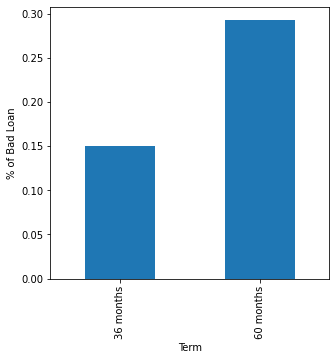

In [66]:
#  Term w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df_test.groupby('Term').mean()['Bad_Loan'].plot.bar()
plt.ylabel("% of Bad Loan")

In [67]:
pd.crosstab(df_test['Term'],df_test['Bad_Loan'])

Bad_Loan,0,1
Term,,
36 months,106064,18720
60 months,23481,9731


In [68]:
_,pval,_,_=chi2_contingency(pd.crosstab(df_test['Term'],df_test['Bad_Loan']))
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

0.0
Reject null hypothesis


#### According to chi2 test, Bad_Loan is dependent upon Term

Text(0, 0.5, '% of Bad Loan')

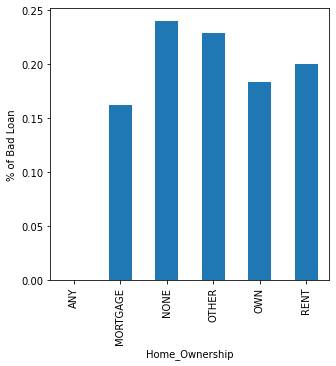

In [69]:
#  Home_Ownership w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df_test.groupby('Home_Ownership').mean()['Bad_Loan'].plot.bar()
plt.ylabel("% of Bad Loan")

In [70]:
pd.crosstab(df_test['Home_Ownership'],df_test['Bad_Loan'])

Bad_Loan,0,1
Home_Ownership,,
ANY,1,0
MORTGAGE,64500,12447
NONE,19,6
OTHER,118,35
OWN,10244,2309
RENT,54663,13654


In [71]:
_,pval,_,_=chi2_contingency(pd.crosstab(df_test['Home_Ownership'],df_test['Bad_Loan']))
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

9.487558838649139e-76
Reject null hypothesis


#### According to chi2 test, Bad_Loan is dependent upon Home_Ownership

Text(0, 0.5, '% of Bad Loan')

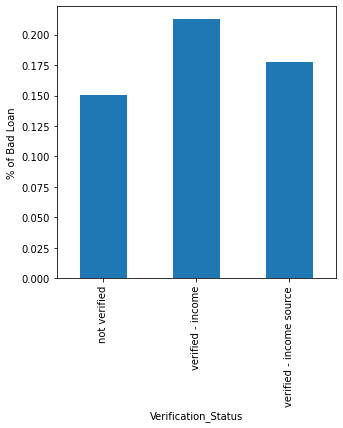

In [72]:
#  Verification_Status w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df_test.groupby('Verification_Status').mean()['Bad_Loan'].plot.bar()
plt.ylabel("% of Bad Loan")

In [73]:
pd.crosstab(df_test['Verification_Status'],df_test['Bad_Loan'])

Bad_Loan,0,1
Verification_Status,,
not verified,49626,8773
verified - income,44810,12089
verified - income source,35109,7589


In [74]:
_,pval,_,_=chi2_contingency(pd.crosstab(df_test['Verification_Status'],df_test['Bad_Loan']))
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

2.1957719311743564e-165
Reject null hypothesis


#### According to chi2 test, Bad_Loan is dependent upon Verification_Status

Text(0, 0.5, '% of Bad Loan')

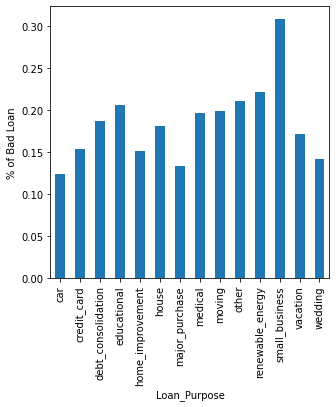

In [75]:
#  Loan_Purpose w.r.t Bad_Loan
plt.figure(figsize=(5,5))
df_test.groupby('Loan_Purpose').mean()['Bad_Loan'].plot.bar()
plt.ylabel("% of Bad Loan")

In [76]:
pd.crosstab(df_test['Loan_Purpose'],df_test['Bad_Loan'])

Bad_Loan,0,1
Loan_Purpose,,
car,2385,339
credit_card,25023,4546
debt_consolidation,73396,16872
educational,323,84
home_improvement,7999,1429
house,979,217
major_purchase,3882,599
medical,1537,375
moving,1116,278


In [77]:
_,pval,_,_=chi2_contingency(pd.crosstab(df_test['Loan_Purpose'],df_test['Bad_Loan']))
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

5.625881232285284e-173
Reject null hypothesis


#### According to chi2 test, Bad_Loan is dependent upon Loan_Purpose

Text(0, 0.5, '% of Bad Loan')

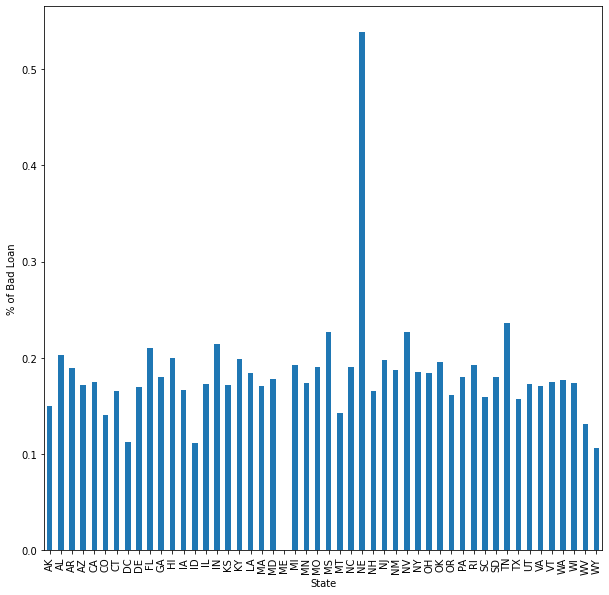

In [78]:
#  State w.r.t Bad_Loan
plt.figure(figsize=(10,10))
df_test.groupby('State').mean()['Bad_Loan'].plot.bar()
plt.ylabel("% of Bad Loan")

In [79]:
pd.crosstab(df_test['State'],df_test['Bad_Loan'])

Bad_Loan,0,1
State,,
AK,340,60
AL,1490,379
AR,852,199
AZ,3085,641
CA,22873,4852
CO,2931,479
CT,2072,411
DC,505,64
DE,352,72


In [80]:
_,pval,_,_=chi2_contingency(pd.crosstab(df_test['State'],df_test['Bad_Loan']))
print(float(pval))
if pval<0.05:
    print("Reject null hypothesis")
else:
    print("Failed to reject null hypothesis")

4.445047202867401e-48
Reject null hypothesis


#### According to chi2 test, Bad_Loan is dependent upon State

In [81]:
del df_test

# Missing value Imputation

In [82]:
#Missing Values
pd.DataFrame(pd.concat([df.isnull().sum(),df.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
Revolving_Cr_Util,194,0.118301
Delinquent_2yr,30,0.018294
Total_Accounts,30,0.018294
Longest_Credit_Length,30,0.018294
Annual_Income,5,0.003049
Loan_Amount,1,0.000610
Term,1,0.000610
Interest_Rate,1,0.000610
Home_Ownership,1,0.000610
Verification_Status,1,0.000610


In [83]:
df1 = pd.DataFrame(df.isna().sum(axis = 1).sort_values(ascending = False))
df1 = df1[df1[0]>0]
index = df1.index
df.loc[index,:].head(50)

,Loan_Amount,Term,Interest_Rate,Home_Ownership,Annual_Income,Verification_Status,Loan_Purpose,State,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length
36285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOOD,NaN
38950,7000.0,36 months,7.75,NONE,NaN,not verified,other,NY,1.00,NaN,NaN,NaN,GOOD,NaN
39033,6500.0,36 months,8.38,NONE,NaN,not verified,other,NY,4.00,NaN,NaN,NaN,GOOD,NaN
38980,6700.0,36 months,7.75,NONE,NaN,not verified,other,NY,1.00,NaN,NaN,NaN,GOOD,NaN
38949,5000.0,36 months,7.43,NONE,NaN,not verified,other,NY,1.00,NaN,NaN,NaN,GOOD,NaN
39019,2500.0,36 months,7.43,MORTGAGE,66624.0,not verified,other,OH,10.36,NaN,NaN,NaN,GOOD,NaN
39028,2000.0,36 months,9.96,RENT,6000.0,not verified,other,FL,10.00,NaN,NaN,NaN,GOOD,NaN
39026,3000.0,36 months,9.01,RENT,35000.0,not verified,other,KS,10.00,NaN,NaN,NaN,GOOD,NaN
39025,10500.0,36 months,11.22,RENT,60000.0,not verified,other,CT,19.50,NaN,NaN,NaN,GOOD,NaN
39024,1275.0,36 months,12.49,RENT,40000.0,not verified,other,MA,10.00,NaN,NaN,NaN,BAD,NaN


In [84]:
# Row wise nummber of missing values greater than 1
df1[df1[0]>1]

,0
36285,13
38950,5
39033,5
38980,5
38949,5
39019,4
39028,4
39026,4
39025,4
39024,4


#### We will drop those observations having total missing values within that row >2

In [85]:
index = df1[df1[0]>2].index
df = df.drop(index).reset_index(drop = True)
print("Missing values removed:",len(index))
df.shape

Missing values removed: 30


(163958, 14)

In [86]:
del df1,index

In [87]:
#Missing Values
pd.DataFrame(pd.concat([df.isnull().sum(),df.isnull().mean()*100],axis=1)).rename(columns={0:"Count",1:"Percentage"}).sort_values('Percentage',ascending=False)

,Count,Percentage
Revolving_Cr_Util,164,0.100026
Loan_Amount,0,0.000000
Term,0,0.000000
Interest_Rate,0,0.000000
Home_Ownership,0,0.000000
Annual_Income,0,0.000000
Verification_Status,0,0.000000
Loan_Purpose,0,0.000000
State,0,0.000000
Debt_to_Income,0,0.000000


In [88]:
df['Revolving_Cr_Util'].describe()

count    163794.000000
mean         54.079173
std          25.285367
min           0.000000
25%          35.600000
50%          55.800000
75%          74.200000
max         150.700000
Name: Revolving_Cr_Util, dtype: float64

In [89]:
df['Revolving_Cr_Util'] = df['Revolving_Cr_Util'].fillna(df['Revolving_Cr_Util'].mean())

In [90]:
df['Bad_Loan'] = df['Bad_Loan'].map({'BAD':1,'GOOD':0})
df.head()

,Loan_Amount,Term,Interest_Rate,Home_Ownership,Annual_Income,Verification_Status,Loan_Purpose,State,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length
0,5000.0,36 months,10.65,RENT,24000.0,verified - income,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0
1,2500.0,60 months,15.27,RENT,30000.0,verified - income source,car,GA,1.00,0.0,9.4,4.0,1,12.0
2,2400.0,36 months,15.96,RENT,12252.0,not verified,small_business,IL,8.72,0.0,98.5,10.0,0,10.0
3,10000.0,36 months,13.49,RENT,49200.0,verified - income source,other,CA,20.00,0.0,21.0,37.0,0,15.0
4,5000.0,36 months,7.90,RENT,36000.0,verified - income source,wedding,AZ,11.20,0.0,28.3,12.0,0,7.0


In [91]:
df.isna().sum()

Loan_Amount              0
Term                     0
Interest_Rate            0
Home_Ownership           0
Annual_Income            0
Verification_Status      0
Loan_Purpose             0
State                    0
Debt_to_Income           0
Delinquent_2yr           0
Revolving_Cr_Util        0
Total_Accounts           0
Bad_Loan                 0
Longest_Credit_Length    0
dtype: int64

In [92]:
df_model = pd.get_dummies(df,drop_first=True)
df_model.head()

,Loan_Amount,Interest_Rate,Annual_Income,Debt_to_Income,Delinquent_2yr,Revolving_Cr_Util,Total_Accounts,Bad_Loan,Longest_Credit_Length,Term_60 months,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,5000.0,10.65,24000.0,27.65,0.0,83.7,9.0,0,26.0,0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,15.27,30000.0,1.00,0.0,9.4,4.0,1,12.0,1,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,15.96,12252.0,8.72,0.0,98.5,10.0,0,10.0,0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,13.49,49200.0,20.00,0.0,21.0,37.0,0,15.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5000.0,7.90,36000.0,11.20,0.0,28.3,12.0,0,7.0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
y = df_model.pop('Bad_Loan')
x = df_model

In [94]:
y.value_counts()

0    133945
1     30013
Name: Bad_Loan, dtype: int64

In [95]:
smote = SMOTE(n_jobs=-1,random_state = 0)
x_train_smote, y_train_smote = smote.fit_sample(x, y)

In [96]:
y_train_smote.value_counts()

0    133945
1    133945
Name: Bad_Loan, dtype: int64

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x_train_smote,y_train_smote,test_size = 0.25, random_state = 123,stratify = y_train_smote)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(200917, 78) (66973, 78) (200917,) (66973,)


# Logistic Regression

In [98]:
scalar1 = StandardScaler()
x_train_scaled = scalar1.fit_transform(x_train)
x_test_scaled = scalar1.transform(x_test)

In [99]:
LR = LogisticRegression(random_state=0, n_jobs=-1)
LR.fit(x_train_scaled,y_train)
y_pred_LR = LR.predict(x_test_scaled)
y_pred_LR_prob = LR.predict_proba(x_test_scaled)[:,1]
print("Train Accuracy: ",LR.score(x_train_scaled,y_train))
print("Test Accuracy: ",LR.score(x_test_scaled,y_test))
print("AUC Score:",roc_auc_score(y_test, y_pred_LR_prob))

Train Accuracy:  0.8775016549122274
Test Accuracy:  0.8804742209547131
AUC Score: 0.9294129042715661


In [100]:
pd.crosstab(y_test,y_pred_LR)

col_0,0,1
Bad_Loan,,
0,32836,651
1,7354,26132


In [101]:
conf_mat = confusion_matrix(y_test,y_pred_LR)
conf_mat

array([[32836,   651],
       [ 7354, 26132]], dtype=int64)

In [102]:
k = classification_report(y_test, y_pred_LR)
print(k)

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     33487
           1       0.98      0.78      0.87     33486

    accuracy                           0.88     66973
   macro avg       0.90      0.88      0.88     66973
weighted avg       0.90      0.88      0.88     66973



In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_LR_prob)

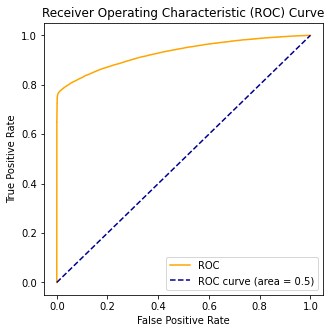

In [104]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Random Forest Classifier

In [105]:
RF = RandomForestClassifier(random_state = 0,n_jobs = -1)
RF.fit(x_train, y_train)
y_pred_RF = RF.predict(x_test)
y_pred_RF_prob = RF.predict_proba(x_test)[:,1]
print("Train Accuracy: ",RF.score(x_train,y_train))
print("Test Accuracy: ",RF.score(x_test,y_test))
print("AUC Score:",roc_auc_score(y_test, y_pred_RF_prob))

Train Accuracy:  1.0
Test Accuracy:  0.8742926253863498
AUC Score: 0.929260491413744


In [106]:
pd.crosstab(y_test,y_pred_RF)

col_0,0,1
Bad_Loan,,
0,32326,1161
1,7258,26228


In [107]:
conf_mat = confusion_matrix(y_test,y_pred_RF)
conf_mat

array([[32326,  1161],
       [ 7258, 26228]], dtype=int64)

In [108]:
k = classification_report(y_test, y_pred_RF)
print(k)

              precision    recall  f1-score   support

           0       0.82      0.97      0.88     33487
           1       0.96      0.78      0.86     33486

    accuracy                           0.87     66973
   macro avg       0.89      0.87      0.87     66973
weighted avg       0.89      0.87      0.87     66973



In [ ]:
index = 0
max_test = 0
train_score = 0
for i in range(1,72,5):
    sys.stderr.write("%d "%i)
    for j in range(2,503,100):
        for k in range(1,202,100):
            for l in range(2,83,10):
                RF1 = RandomForestClassifier(max_depth = i,min_samples_split = j,min_samples_leaf = k,max_leaf_nodes = l,random_state = 0,n_jobs = -1)
                RF1.fit(x_train, y_train)
                if (max_test < RF1.score(x_test, y_test)) and (RF1.score(x_test, y_test)<=RF1.score(x_train, y_train)):
                    max_test = RF1.score(x_test, y_test)
                    train_score = RF1.score(x_train, y_train)
                    index = i,j,k,l

1 6 11 16 21 26 31 36 41 46 

In [ ]:
print("Desired parameters: ",index)
print("Train Score: ",train_score)
print("Test Score: ",max_test)

# XGBoost Classifier

In [ ]:
XGB = XGBClassifier(objective='binary:logistic',n_jobs = -1,random_state=0)
XGB.fit(x_train, y_train,eval_set=[(x_test,y_test)],eval_metric = "error",verbose=False)
y_pred0_XGB_prob = XGB.predict_proba(x_train)[:,1]
y_pred_XGB = XGB.predict(x_test)
y_pred_XGB_prob = XGB.predict_proba(x_test)[:,1]
print("Train Accuracy: ",XGB.score(x_train,y_train))
print("Test Accuracy: ",XGB.score(x_test,y_test))
print("AUC Score for Train:",roc_auc_score(y_train, y_pred0_XGB_prob))
print("AUC Score for Test:",roc_auc_score(y_test, y_pred_XGB_prob))

In [ ]:
XGB.score(x_test,y_test)

In [ ]:
y_pred_XGB = XGB.predict(x_test)

In [ ]:
accuracy_score(y_test,y_pred_XGB)

In [ ]:
pd.crosstab(y_test,y_pred_XGB)

In [ ]:
conf_mat = confusion_matrix(y_test,y_pred_XGB)
conf_mat

In [ ]:
k = classification_report(y_test, y_pred_XGB)
print(k)

In [ ]:
index = 0
max_test = 0
train_score = 0
for i in range(100,501,50):
    sys.stderr.write("\n%d "%i)
    for j in range(2,21,2):
        sys.stderr.write("%d "%j)
        for k in [0.05,0.1,0.15]:
            XGB1 = XGBClassifier(n_jobs = -1,n_estimators = i,max_depth = j,learning_rate = k)
            XGB1.fit(x_train, y_train,eval_set=[(x_test, y_test)],eval_metric="error",verbose = False)
            y_pred0_testing = XGB1.predict(x_train)
            y_pred_testing = XGB1.predict(x_test)
            accuracy_train = accuracy_score(y_train,y_pred0_testing)
            accuracy_test = accuracy_score(y_test,y_pred_testing)
            if (max_test < accuracy_test) and (accuracy_test <= accuracy_train):
                    max_test = accuracy_test
                    train_score = accuracy_train
                    index = i,j,k

In [ ]:
print("Desired parameters: ",index)
print("Train Score: ",train_score)
print("Test Score: ",max_test)

In [ ]:
# finding out max accuracy that can be attained using ROC curve
max = 0
index = 0
train_score = 0
for i in np.linspace(0,1,101):
    y_pred0_testing = y_pred0_XGB_prob.copy()
    y_pred_testing = y_pred_XGB_prob.copy()
    y_pred0_testing[y_pred0_testing>=i] = 1
    y_pred0_testing[y_pred0_testing<i] = 0
    y_pred_testing[ y_pred_testing>=i] = 1
    y_pred_testing[ y_pred_testing<i] = 0
    
    accuracy_train = accuracy_score(y_train,y_pred0_testing)
    accuracy_test = accuracy_score(y_test,y_pred_testing)

    if((accuracy_test>max) and (accuracy_train>accuracy_test)):
        max = accuracy_test
        index = i
        train_score = accuracy_train
print(index, train_score,max)